# Model HONEST.AI
- Data explanatory
- Data cleaning
- Data Pre-processing
- Train model
- model evaluation
- save model

### Data Explanatori

In [10]:
# Data 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
import re
import joblib
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

In [11]:
df = pd.read_csv('Data_latih.csv')

In [12]:
df.head(5)

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [13]:
df['narasi'].isnull().sum()

0

C:\Users\danie\AppData\Local\Temp\ipykernel_11208\1305591981.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


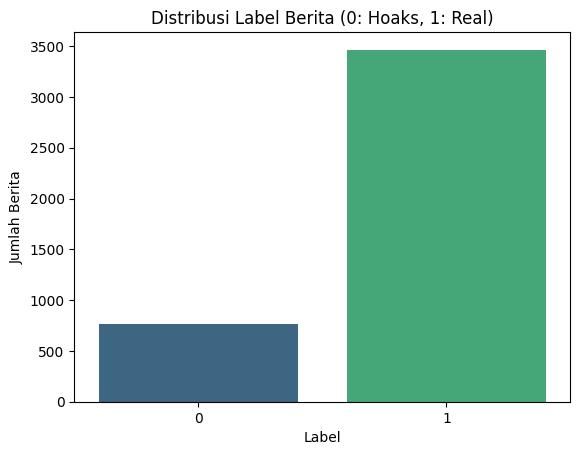

In [14]:
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Label Berita (0: Hoaks, 1: Real)')
plt.xlabel('Label')
plt.ylabel('Jumlah Berita')
plt.show()

In [15]:
df.describe()

,ID,label
count,4231.000000,4231.000000
mean,495577.536753,0.818955
std,288916.337205,0.385101
min,71.000000,0.000000
25%,244075.500000,1.000000
50%,496444.000000,1.000000
75%,749050.000000,1.000000
max,999860.000000,1.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4231 non-null   int64 
 1   label             4231 non-null   int64 
 2   tanggal           4231 non-null   object
 3   judul             4231 non-null   object
 4   narasi            4231 non-null   object
 5   nama file gambar  4231 non-null   object
dtypes: int64(2), object(4)
memory usage: 198.5+ KB


### Data Cleaning

In [17]:
df = df.drop(['ID','tanggal','judul','nama file gambar'], axis=1)

### Data Preprocessing

In [18]:
nltk.download("stopwords")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("indonesian"))
spell = SpellChecker(language="en")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [spell.correction(w) if spell.correction(w) else w for w in words]
    words = [stemmer.stem(w) for w in words]
    return " ".join(words)


### Sentiment analisis dari data

In [20]:
# Fungsi Sentimen Analisis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity 

# Fungsi untuk mendapatkan panjang teks
def get_text_length(text):
    return len(text)

# Fungsi untuk mendapatkan jumlah kata
def get_word_count(text):
    return len(text.split())

# Terapkan fungsi ke dataset
df['sentiment'] = df['narasi'].apply(get_sentiment)
df['text_length'] = df['narasi'].apply(get_text_length)
df['word_count'] = df['narasi'].apply(get_word_count)

# Simpan dataset baru
df.to_csv("dataset_processed.csv", index=False)  

In [21]:
vect = TfidfVectorizer(max_features=5000)

### Train Model (modeling)

In [22]:
# Transformer untuk fitur tambahan
text_length_transformer = FunctionTransformer(lambda x: x[['text_length']], validate=False)
word_count_transformer = FunctionTransformer(lambda x: x[['word_count']], validate=False)
sentiment_transformer = FunctionTransformer(lambda x: x[['sentiment']], validate=False)

# Gabungkan semua fitur
feature_union = FeatureUnion([
    ('tfidf', vect),
    ('text_length', text_length_transformer),
    ('word_count', word_count_transformer),
    ('sentiment', sentiment_transformer)
])

In [23]:
df = pd.read_csv("dataset_processed.csv")

In [24]:
X = df[['narasi', 'text_length', 'word_count', 'sentiment']]
y = df['label']

In [25]:
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(max_features=5000), 'narasi'),
    ('text_length', FunctionTransformer(lambda x: x, validate=False), ['text_length']),
    ('word_count', FunctionTransformer(lambda x: x, validate=False), ['word_count']),
    ('sentiment', FunctionTransformer(lambda x: x, validate=False), ['sentiment']),
])

In [26]:
X_transformed = preprocessor.fit_transform(X)

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

In [28]:
X_train_vect = vect.fit_transform(X_train['narasi'])

In [29]:
X_test = vect.transform(X_test['narasi'])

In [30]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_vect, y_train)

In [31]:
df_smote = pd.DataFrame({'label': y_train})

Contoh data dari hasil SMOTE:
   label
0      0
1      1
2      1
3      0
4      1

Distribusi label setelah SMOTE:
label
0    2757
1    2757
Name: count, dtype: int64


C:\Users\danie\AppData\Local\Temp\ipykernel_11208\3975677843.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel')


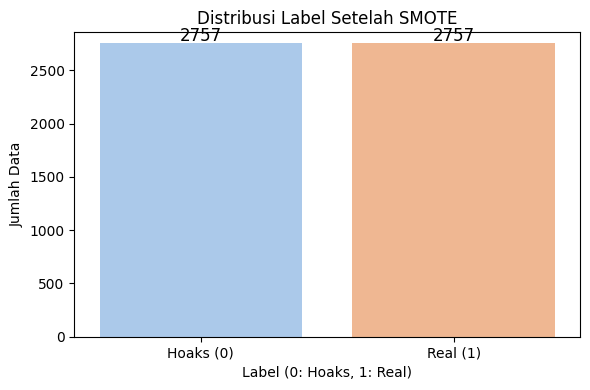

In [32]:
# Tampilkan beberapa data hasil SMOTE
print("Contoh data dari hasil SMOTE:")
print(df_smote.head())

# Hitung jumlah tiap label
label_counts = df_smote['label'].value_counts().sort_index()
print("\nDistribusi label setelah SMOTE:")
print(label_counts)

# Plot distribusi label setelah SMOTE
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel')
plt.title('Distribusi Label Setelah SMOTE')
plt.xlabel('Label (0: Hoaks, 1: Real)')
plt.ylabel('Jumlah Data')
plt.xticks([0, 1], ['Hoaks (0)', 'Real (1)'])
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 20, str(count), ha='center', fontsize=12)
plt.ylim(0, max(label_counts.values) + 100)
plt.tight_layout()
plt.show()

#### Train hyper tunning parameter naive bayes

In [33]:
param_grid_nb = {"alpha": [0.1, 0.5, 1.0, 2.0, 5.0]}

In [34]:
nb = MultinomialNB()

In [35]:
grid_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring="accuracy", n_jobs=-1)
grid_nb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]},
             scoring='accuracy')

In [36]:
best_nb = grid_nb.best_estimator_
print("Best params Naïve Bayes:", grid_nb.best_params_)
print("Best accuracy Naïve Bayes:", grid_nb.best_score_)

Best params Naïve Bayes: {'alpha': 0.1}
Best accuracy Naïve Bayes: 0.89698940194454


#### Train Hyper tunning parameter Random forest

In [37]:
param_grid_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [38]:
rf = RandomForestClassifier(random_state=42)

In [39]:
random_rf = RandomizedSearchCV(rf, param_grid_rf, cv=3, scoring="accuracy", n_jobs=-1, n_iter=10, random_state=42)
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [40]:
best_rf = random_rf.best_estimator_
print("Best params Random Forest:", random_rf.best_params_)
print("Best accuracy Random Forest:", random_rf.best_score_)

Best params Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best accuracy Random Forest: 0.9221980413492927


### Model evaluation

In [41]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_true, y_pred_nb, y_pred_rf = [], [], []

for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit & prediksi dengan Naïve Bayes
    nb.fit(X_train_fold, y_train_fold)
    y_pred_nb_fold = nb.predict(X_test_fold)

    # Fit & prediksi dengan Random Forest
    rf.fit(X_train_fold, y_train_fold)
    y_pred_rf_fold = rf.predict(X_test_fold)

    # Simpan hasil asli & prediksi
    y_true.extend(y_test_fold)  
    y_pred_nb.extend(y_pred_nb_fold)
    y_pred_rf.extend(y_pred_rf_fold)

# Evaluasi akurasi model
acc_nb = accuracy_score(y_true, y_pred_nb)
acc_rf = accuracy_score(y_true, y_pred_rf)

print(f"Final K-Fold CV Accuracy (Naïve Bayes): {acc_nb:.4f}")
print(f"Final K-Fold CV Accuracy (Random Forest): {acc_rf:.4f}")

Final K-Fold CV Accuracy (Naïve Bayes): 0.8513
Final K-Fold CV Accuracy (Random Forest): 0.9314


### Voting classifier

In [42]:
# Voting Classifier (Gabungkan Model)
voting_clf = VotingClassifier(estimators=[
    ('naive_bayes', best_nb),
    ('random_forest', best_rf)
], voting='soft')

In [43]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('naive_bayes', MultinomialNB(alpha=0.1)),
                             ('random_forest',
                              RandomForestClassifier(max_features='log2',
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     random_state=42))],
                 voting='soft')

In [44]:
accuracy = voting_clf.score(X_test, y_test)
y_pred = voting_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Voting Classifier Accuracy: {accuracy:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.27      0.34       139
           1       0.87      0.93      0.90       708

    accuracy                           0.83       847
   macro avg       0.66      0.60      0.62       847
weighted avg       0.80      0.83      0.81       847

Confusion Matrix:
 [[ 38 101]
 [ 47 661]]
Voting Classifier Accuracy: 0.8253


### Penyimpanan model

In [45]:
model = joblib.dump(voting_clf,'model_Honest_AI.pkl')
vect = joblib.dump(vect,'vectorizer.pkl')